In [1]:
from cluster_half_shelfs_alpha import Half_shelf_cluster
import numpy as np
import cv2 as cv
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from matplotlib import pyplot as plt
from confectionery import Confectionery



In [2]:
# create object and load data
object_trajectory=my_data = np.genfromtxt('/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/object_0_trajectory.csv', delimiter=',')
object_trajectory=object_trajectory[1:,:]
stream_string=[]
koppenrath=Confectionery()
for i in range(object_trajectory.shape[0]):
    frame_number=round(object_trajectory[i,0])
    im_path="Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t"+str(frame_number).zfill(3)+".jpg"
    stream_string.append(im_path)
# cluster
half_shelf_cluster=Half_shelf_cluster(object_trajectory, stream_string, cut_radius=11, confectionery=koppenrath)
half_shelf_cluster.load_data_initial(frame_portion=1.0)

987

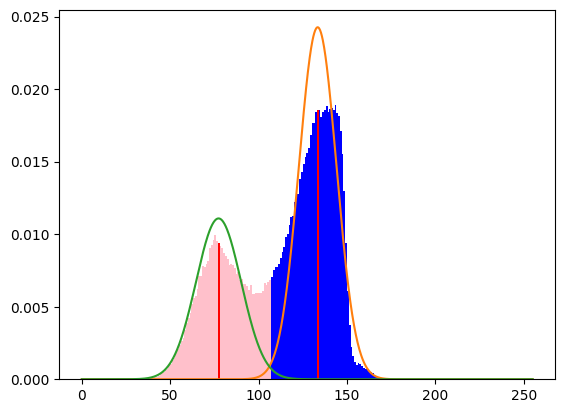

[133.41152959  77.35782781]


In [3]:
half_shelf_cluster.train_gmm_cutoff_filter(cut_off_probability=0.85,plot_hist=True)
print(half_shelf_cluster.means_gmm_cutoff_filter)


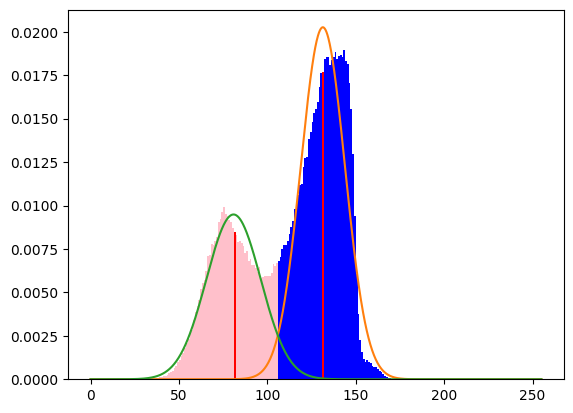

[131.38366697  80.87975777]
[155.82901026 237.00331723]
[0.63396019 0.36603981]


In [4]:
half_shelf_cluster.train_gmm(plot_hist=True)
print(half_shelf_cluster.means_gmm)
print(half_shelf_cluster.variance)
print(half_shelf_cluster.priors_gmm)

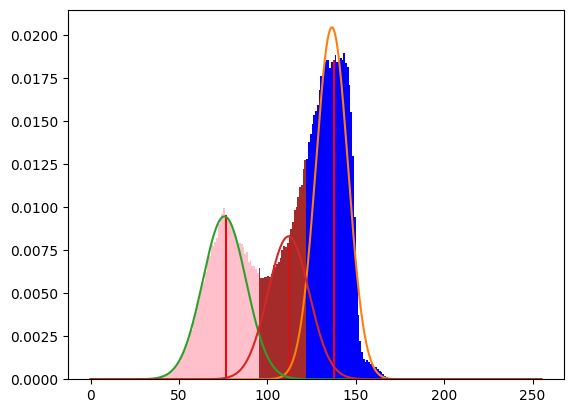

[136.50748875  75.71410265 111.96752937]


In [5]:
half_shelf_cluster.train_gmm(number_of_gaussian=3, plot_hist=True)
print(half_shelf_cluster.means_gmm)


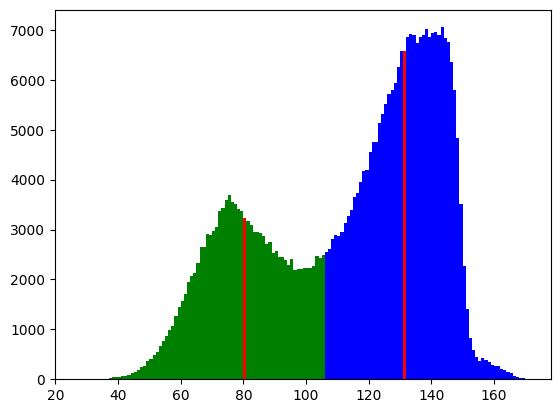

[131.39646592  79.88700924]


In [6]:
half_shelf_cluster.train_2_means(plot_hist=True)
print(half_shelf_cluster.centroids_kmeans)

In [7]:
data=half_shelf_cluster.data
N=10
means_orig=[132.718,  82.071]
var_orig=[143.228, 229.329]
prior_orig=[0.643, 0.357]
data_batch=np.copy(data[np.random.choice(data.shape[0], N, replace=False)])
gmm = GaussianMixture(n_components=2, random_state=0).fit(data_batch.reshape((-1,1)))
priors_gmm = gmm.weights_
means_gmm = gmm.means_.reshape((-1))
variance = gmm.covariances_.reshape((-1))
print(means_gmm)
print(variance)
print(priors_gmm)


[134.01031367  70.16565731]
[198.76395387 117.47632186]
[0.6019978 0.3980022]


In [8]:
start_frame=0
end_frame=999
stream_string=[]
for i in range(start_frame,end_frame+1):
    im_path="Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t"+str(i).zfill(3)+".jpg"
    stream_string.append(im_path)
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
obj_0=my_data = np.genfromtxt('/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/object_0_trajectory.csv', delimiter=',')
obj_0=obj_0[1:,:]

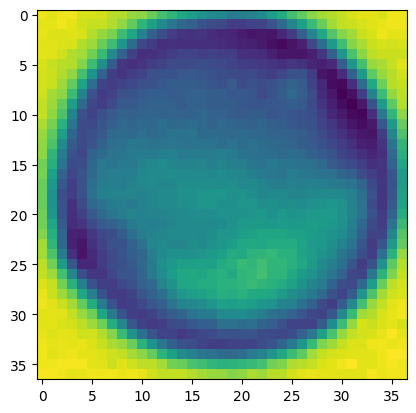

In [9]:
#frame_number=257
#frame_number=85
#frame_number=287
frame_number=523
#frame_number=0
index_number=round(frame_number-obj_0[0,0])
obj_image_current=cv.imread(cv.samples.findFile(stream_string[frame_number]), cv.IMREAD_GRAYSCALE)
object_indeces=np.s_[round(obj_0[index_number,2]-np.ceil(obj_0[index_number,3])):round(obj_0[index_number,2]+np.ceil(obj_0[index_number,3]))+1,
                     round(obj_0[index_number,1]-np.ceil(obj_0[index_number,3])):round(obj_0[index_number,1]+np.ceil(obj_0[index_number,3]))+1]
obj_image_current=obj_image_current[object_indeces]

plt.figure()
plt.imshow(obj_image_current)
plt.show()

(37, 37)
(441,)


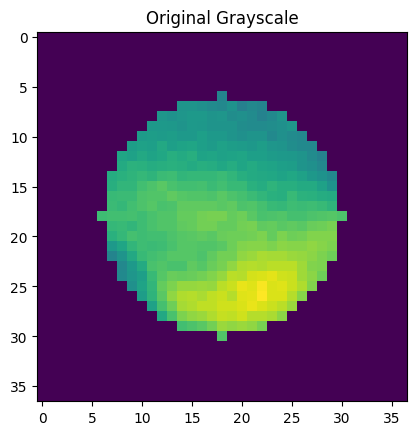

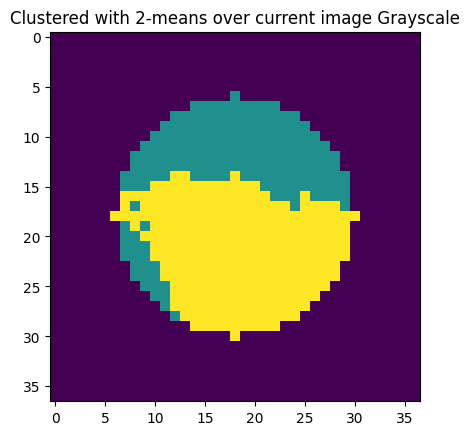

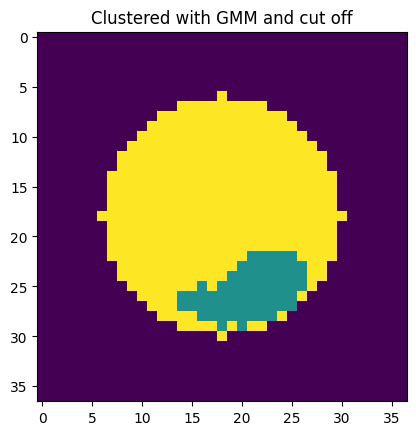

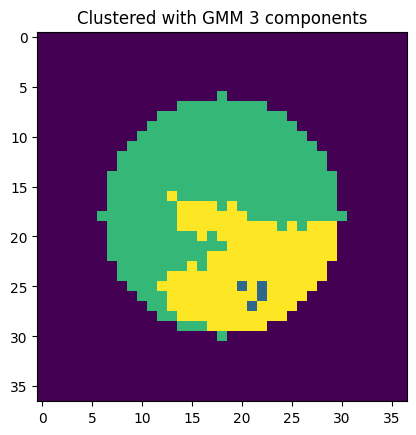

In [10]:
image_shape=obj_image_current.shape
cut_radius=round(np.floor(obj_0[index_number,-1]*0.7))
M=koppenrath.sell_cake(cut_radius,obj_image_current.shape[0],obj_image_current.shape[0])


object_pixels=np.copy(obj_image_current)
object_pixels=np.float32(object_pixels[M==1])
print((M==1).shape)
print(object_pixels.shape)
attempts=10
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv.kmeans(object_pixels, 2, None, criteria, attempts, cv.KMEANS_RANDOM_CENTERS)

label=label+1
object_clustered=np.zeros(image_shape,np.uint8)
object_clustered[M==1]=label.reshape(-1)

obj_image_current[M==0]=0

plt.figure()
plt.title("Original Grayscale")
plt.imshow(obj_image_current)
plt.show()
plt.figure()
plt.title("Clustered with 2-means over current image Grayscale")
plt.imshow(object_clustered)
plt.show()


object_pixels=np.copy(obj_image_current)
object_pixels=np.float32(object_pixels[M==1])

label=half_shelf_cluster.gmm_cutoff_filter.predict(object_pixels.reshape((-1,1)))

label=label+1
object_clustered=np.zeros(image_shape,np.uint8)
object_clustered[M==1]=label.reshape(-1)

obj_image_current[M==0]=0

plt.figure()
plt.title("Clustered with GMM and cut off")
plt.imshow(object_clustered)
plt.show()


object_pixels=np.copy(obj_image_current)
object_pixels=np.float32(object_pixels[M==1])

label=half_shelf_cluster.gmm.predict(object_pixels.reshape((-1,1)))

label=label+1
object_clustered=np.zeros(image_shape,np.uint8)
object_clustered[M==1]=label.reshape(-1)

obj_image_current[M==0]=0
plt.figure()
plt.title("Clustered with GMM 3 components")
plt.imshow(object_clustered)
plt.show()


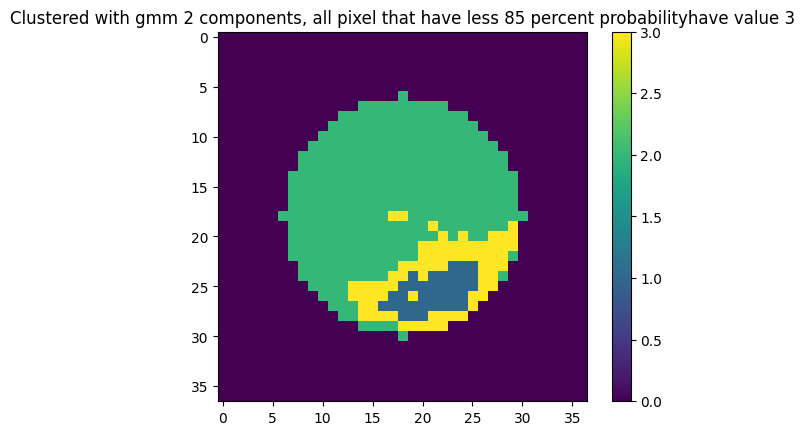

In [11]:
# label only with 85% margin
half_shelf_cluster.train_gmm(number_of_gaussian=2, plot_hist=False)
object_pixels=np.copy(obj_image_current)
object_pixels=np.float32(object_pixels[M==1])

prob=half_shelf_cluster.gmm.predict_proba(object_pixels.reshape((-1,1)))
label=half_shelf_cluster.gmm.predict(object_pixels.reshape((-1,1)))
prob_post=np.max(prob, axis=1)
label[prob_post<0.85]=2
label=label+1
object_clustered=np.zeros(image_shape,np.uint8)
object_clustered[M==1]=label.reshape(-1)

obj_image_current[M==0]=0
plt.figure()
plt.title("Clustered with gmm 2 components, all pixel that have less 85 percent probabilityhave value 3")
plt.imshow(object_clustered)
plt.colorbar()
plt.show()

In [12]:
"Ideas to add spatial component, Mean filter and then GMM (aka add 4 surroduning pixels-> y=1/5 (x1+x2+x3+x4+x5), then apply gmm on y)"
"Consider 5 tupel (pixel and sorrounding pixel) as input space cluster center should be around (0,0,0,0,0) and (1,1,1,1,1), how many clusters? "

'Consider 5 tupel (pixel and sorrounding pixel) as input space cluster center should be around (0,0,0,0,0) and (1,1,1,1,1), how many clusters? '